#### Dependencies

In [249]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import yaml
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda
import mnist_dataset
from hydra import initialize, compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from difflogic import LogicLayer, GroupSum
from mnist_dataset import MNISTRemoveBorderTransform

#### Dataset

Tunable Variables

In [256]:
# Configurable options
remove_border = True       # True: Removes border of Mnist, False: Keeps black border around digits
binarize_images = True     # True: Binarized Images, False: Grayscale Images 
evenly_partitioned = True  # True: Even distribution of samples, False: Original Mnist distribution
upscaled_images = False    # True: Upscales the samples to 32x32, False: Keeps size unchanged
downscaled_images = True   # True: Downscales the samples to 16x16, False: Keeps size unchanged
batch_size = 256           # Batch size

Dataset Transform

In [257]:
# function to binarize an image, threshold is tunable 
def binarize(image, threshold=0.5):
    return (image > threshold).float()  

# define the transformation logic based on the toggle
transform_list = [ToTensor()]

if remove_border:
    transform_list.append(MNISTRemoveBorderTransform())
    
if upscaled_images:
    transform_list.append(Resize((32, 32)))
elif downscaled_images:
    transform_list.append(Resize((16, 16)))
if binarize_images:
    transform_list.append(Lambda(lambda x: binarize(x)))
    
# adds binarization if enabled
if binarize_images:
    transform_list.append(Lambda(lambda x: binarize(x)))
    
transform = Compose(transform_list)

In [258]:
train_dataset = mnist_dataset.MNIST('./data-mnist', train=True, download=True, transform=transform)
test_dataset = mnist_dataset.MNIST('./data-mnist', train=False, transform=transform)

# drop_last = True means it will drop the last incomplete Batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [259]:
# makes the Dataset evenly partitioned
if evenly_partitioned:
    # code below is used so that all classes have the same number of samples
    train_targets = train_loader.dataset.targets
    test_targets = test_loader.dataset.targets

    train_digits_total = []
    test_digits_total = []

    for i in range(10):
        curr_tot_train = torch.sum(train_targets == i).item()
        curr_tot_test = torch.sum(test_targets == i).item()    
        train_digits_total.append(curr_tot_train)
        test_digits_total.append(curr_tot_test)

    train_digits_total, test_digits_total

    # find the minimum number of samples across all classes
    min_samples_train = min(train_digits_total)
    min_samples_test = min(test_digits_total)

    # function to trim dataset to match the minimum samples for each class and shuffle indices
    def trim_dataset(dataset, targets, min_samples):
        indices = []
        for i in range(10):
            class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
            class_indices = class_indices[:min_samples]  # trim to min_samples
            indices.extend(class_indices)

        # shuffle indices after collecting them
        indices = torch.tensor(indices)
        indices = indices[torch.randperm(indices.size(0))]  

        return Subset(dataset, indices)

    # trim both train and test datasets to ensure all classes have the same number of samples
    trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
    trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

    # create DataLoaders for the trimmed datasets
    trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

    # verify the lengths of the trimmed datasets
    len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

    train_dataset = trimmed_train_dataset
    test_dataset = trimmed_test_dataset
    train_loader = trimmed_train_loader
    test_loader = trimmed_test_loader

In [260]:
sample_size = len(train_loader.dataset) + len(test_loader.dataset)
len(train_loader.dataset), len(test_loader.dataset)

(54210, 8920)

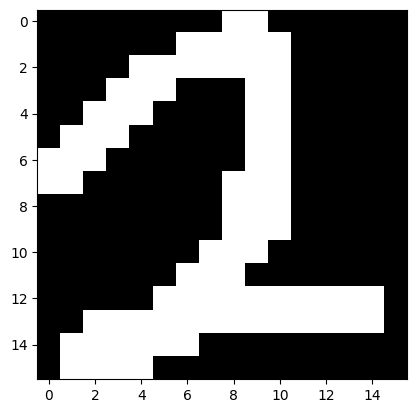

In [261]:
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)

if remove_border and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(20, 20)
elif not remove_border and not upscaled_images and not downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(28, 28)
elif downscaled_images:
    image = train_loader.dataset[random_index][0].reshape(16, 16)
else:
    image = train_loader.dataset[random_index][0].reshape(32, 32)
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [262]:
# define first input and the name of the file to be saved
first_in_dim = 256 # 16x16
filename = "config/mnist_config_16x16.yaml"  

In [263]:
# reads the CSV file into a DataFrame
df = pd.read_csv("config/hyperparameters.csv")

# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_config_16x16.yaml' generated successfully.


#### Model Definition

DiffLogic Class

In [264]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        self.flatten = nn.Flatten()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        x = self.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs)

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [265]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### Model Training

In [276]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="aidays2024"):
    cfg = compose(config_name="mnist_config_16x16")

# training loop for all models
all_models_dict = {}
num_epochs = 50
file_path = 'trained_models/mnist_trained_16x16' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    try:
        # initializes DiffLogic model and moves to CUDA if available
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # optimizer and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        early_stopper = EarlyStopper(patience=5)

        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_loss = 0  # to track loss for an epoch
            
            for batch_inputs, batch_outputs in loop:
                # move data to the appropriate device
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

                # forward pass through the model
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)

                # zero gradients, backpropagates, and updates model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # accumulating the loss for the epoch
                epoch_loss += loss.item()

            # caclulating the average loss for the epoch
            epoch_loss /= len(train_loader)
            all_models_dict[model_name]['losses'].append(epoch_loss)
            print(f'Epoch {epoch+1} Loss: {epoch_loss}')

            # checks for early stopping
            if early_stopper.should_stop(epoch_loss):
                print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
                break

        # saving trained model's state
        model.save(file_path, model_name)

    except Exception as e:
        print(f"ERROR TRAINING {model_name.upper()}: {str(e)}")
    
    # [FOR TESTING] breaks after the first model is trained
    break

print("All models processed.")

training model model_001
LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)


Epoch 1/50: 100%|██████████| 211/211 [00:19<00:00, 10.61it/s]


Epoch 1 Loss: 1.1119424867343153


Epoch 2/50: 100%|██████████| 211/211 [00:13<00:00, 15.65it/s]


Epoch 2 Loss: 0.9228575970252766


Epoch 3/50: 100%|██████████| 211/211 [00:13<00:00, 15.75it/s]


Epoch 3 Loss: 0.9157584791315495


Epoch 4/50: 100%|██████████| 211/211 [00:13<00:00, 15.75it/s]


Epoch 4 Loss: 0.9126646656933024


Epoch 5/50: 100%|██████████| 211/211 [00:13<00:00, 15.71it/s]


Epoch 5 Loss: 0.9104601149709992


Epoch 6/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 6 Loss: 0.9088422102135516


Epoch 7/50: 100%|██████████| 211/211 [00:13<00:00, 15.72it/s]


Epoch 7 Loss: 0.9078710585409017


Epoch 8/50: 100%|██████████| 211/211 [00:13<00:00, 15.67it/s]


Epoch 8 Loss: 0.9070902408030771


Epoch 9/50: 100%|██████████| 211/211 [00:13<00:00, 15.61it/s]


Epoch 9 Loss: 0.9065902625621403


Epoch 10/50: 100%|██████████| 211/211 [00:13<00:00, 15.63it/s]


Epoch 10 Loss: 0.9064018582282989


Epoch 11/50: 100%|██████████| 211/211 [00:13<00:00, 15.63it/s]


Epoch 11 Loss: 0.906346158260878


Epoch 12/50: 100%|██████████| 211/211 [00:13<00:00, 15.68it/s]


Epoch 12 Loss: 0.9062119538660667


Epoch 13/50: 100%|██████████| 211/211 [00:13<00:00, 15.65it/s]


Epoch 13 Loss: 0.905483963964352


Epoch 14/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 14 Loss: 0.9049921845589762


Epoch 15/50: 100%|██████████| 211/211 [00:13<00:00, 15.72it/s]


Epoch 15 Loss: 0.9047782847649316


Epoch 16/50: 100%|██████████| 211/211 [00:13<00:00, 15.75it/s]


Epoch 16 Loss: 0.9044618632463219


Epoch 17/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 17 Loss: 0.9041088065947944


Epoch 18/50: 100%|██████████| 211/211 [00:13<00:00, 15.68it/s]


Epoch 18 Loss: 0.9037859860576604


Epoch 19/50: 100%|██████████| 211/211 [00:13<00:00, 15.75it/s]


Epoch 19 Loss: 0.9039542531642004
EarlyStopper Triggered:  1


Epoch 20/50: 100%|██████████| 211/211 [00:13<00:00, 15.71it/s]


Epoch 20 Loss: 0.9033383289280179


Epoch 21/50: 100%|██████████| 211/211 [00:13<00:00, 15.70it/s]


Epoch 21 Loss: 0.9031940876991053


Epoch 22/50: 100%|██████████| 211/211 [00:13<00:00, 15.68it/s]


Epoch 22 Loss: 0.9034299225428943
EarlyStopper Triggered:  1


Epoch 23/50: 100%|██████████| 211/211 [00:13<00:00, 15.59it/s]


Epoch 23 Loss: 0.9035049728004861
EarlyStopper Triggered:  2


Epoch 24/50: 100%|██████████| 211/211 [00:13<00:00, 15.68it/s]


Epoch 24 Loss: 0.9031599815912031


Epoch 25/50: 100%|██████████| 211/211 [00:14<00:00, 14.42it/s]


Epoch 25 Loss: 0.9028267361961154


Epoch 26/50: 100%|██████████| 211/211 [00:13<00:00, 15.69it/s]


Epoch 26 Loss: 0.9031423220935308
EarlyStopper Triggered:  1


Epoch 27/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 27 Loss: 0.9030594268024787
EarlyStopper Triggered:  2


Epoch 28/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 28 Loss: 0.9026352741234794


Epoch 29/50: 100%|██████████| 211/211 [00:13<00:00, 15.71it/s]


Epoch 29 Loss: 0.9024477082237874


Epoch 30/50: 100%|██████████| 211/211 [00:13<00:00, 15.83it/s]


Epoch 30 Loss: 0.902437583700462


Epoch 31/50: 100%|██████████| 211/211 [00:13<00:00, 15.75it/s]


Epoch 31 Loss: 0.9023544638997535


Epoch 32/50: 100%|██████████| 211/211 [00:13<00:00, 15.80it/s]


Epoch 32 Loss: 0.9019877960275173


Epoch 33/50: 100%|██████████| 211/211 [00:13<00:00, 15.80it/s]


Epoch 33 Loss: 0.9020073140370322
EarlyStopper Triggered:  1


Epoch 34/50: 100%|██████████| 211/211 [00:13<00:00, 15.71it/s]


Epoch 34 Loss: 0.9017785116456836


Epoch 35/50: 100%|██████████| 211/211 [00:13<00:00, 15.80it/s]


Epoch 35 Loss: 0.9018258271791403
EarlyStopper Triggered:  1


Epoch 36/50: 100%|██████████| 211/211 [00:13<00:00, 15.81it/s]


Epoch 36 Loss: 0.9015721189454439


Epoch 37/50: 100%|██████████| 211/211 [00:13<00:00, 15.73it/s]


Epoch 37 Loss: 0.901306280554772


Epoch 38/50: 100%|██████████| 211/211 [00:13<00:00, 15.78it/s]


Epoch 38 Loss: 0.9014117803948192
EarlyStopper Triggered:  1


Epoch 39/50: 100%|██████████| 211/211 [00:13<00:00, 15.76it/s]


Epoch 39 Loss: 0.9017111747525886
EarlyStopper Triggered:  2


Epoch 40/50: 100%|██████████| 211/211 [00:13<00:00, 15.71it/s]


Epoch 40 Loss: 0.9014832049736717
EarlyStopper Triggered:  3


Epoch 41/50: 100%|██████████| 211/211 [00:13<00:00, 15.67it/s]


Epoch 41 Loss: 0.9015589568592135
EarlyStopper Triggered:  4


Epoch 42/50: 100%|██████████| 211/211 [00:13<00:00, 15.62it/s]


Epoch 42 Loss: 0.9016620419474912
EarlyStopper Triggered:  5
Early stopping triggered for model_001 at epoch 42.
All models processed.


#### Model Testing

In [277]:
# testing loop to test inferences
trained_models_dir = 'trained_models/mnist_trained_16x16'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="mnist_config_16x16")

# dictionary to store the trained models
trained_models = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    
    model_cfg = cfg['models'][model_name]
    
    # instantiates the model and load its weights
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_path = os.path.join(trained_models_dir, model_file)
    print(f"Evaluating {model_file}...")

    # loads the respective model
    model.load(model_path)

    # calculates accuracy
    accuracy = model.get_accuracy(test_loader)
    
    print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")
    
    trained_models[i] = model

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.94it/s]


Accuracy of model_001.pth: 84.65%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_002.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]


Accuracy of model_002.pth: 88.99%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_003.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]


Accuracy of model_003.pth: 90.85%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_004.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.89it/s]


Accuracy of model_004.pth: 92.44%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_005.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]


Accuracy of model_005.pth: 92.75%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_006.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.90it/s]


Accuracy of model_006.pth: 86.55%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_007.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.90it/s]


Accuracy of model_007.pth: 90.48%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_008.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.00it/s]


Accuracy of model_008.pth: 92.81%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_009.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.90it/s]


Accuracy of model_009.pth: 93.30%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_010.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.02it/s]


Accuracy of model_010.pth: 94.21%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_011.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.08it/s]


Accuracy of model_011.pth: 86.11%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_012.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.06it/s]


Accuracy of model_012.pth: 90.87%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_013.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.05it/s]


Accuracy of model_013.pth: 92.50%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_014.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.40it/s]


Accuracy of model_014.pth: 93.83%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_015.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.00it/s]


Accuracy of model_015.pth: 94.35%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_016.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 16.01it/s]


Accuracy of model_016.pth: 85.86%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_017.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.97it/s]


Accuracy of model_017.pth: 89.72%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_018.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.98it/s]


Accuracy of model_018.pth: 91.65%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_019.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.93it/s]


Accuracy of model_019.pth: 93.19%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_020.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.96it/s]


Accuracy of model_020.pth: 93.65%

LogicLayer(256, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
LogicLayer(2560, 2560, train)
Evaluating model_021.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.99it/s]


Accuracy of model_021.pth: 82.13%

LogicLayer(256, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
LogicLayer(5120, 5120, train)
Evaluating model_022.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.93it/s]


Accuracy of model_022.pth: 87.64%

LogicLayer(256, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
LogicLayer(7680, 7680, train)
Evaluating model_023.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]


Accuracy of model_023.pth: 89.73%

LogicLayer(256, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
LogicLayer(10240, 10240, train)
Evaluating model_024.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.92it/s]


Accuracy of model_024.pth: 91.26%

LogicLayer(256, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
LogicLayer(12800, 12800, train)
Evaluating model_025.pth...


Running Inference: 100%|██████████| 34/34 [00:02<00:00, 15.89it/s]

Accuracy of model_025.pth: 90.89%



#### Model Optimization (?)

In [7]:
# maybe remove the unused nodes to increase inference speed / decrease energy consumption?

#### Verilog Conversion

Logic gate to Verilog expression mapping

In [278]:
logic_gate_verilog = {
    "0": "1'b0",
    "A∧B": "({a}) & ({b})",
    "¬(A⇒B)": "({a}) & ~({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) & ~({a})",
    "B": "{b}",
    "A⊕B": "({a}) ^ ({b})",
    "A∨B": "({a}) | ({b})",
    "¬(A∨B)": "~(({a}) | ({b}))",
    "¬(A⊕B)": "~(({a}) ^ ({b}))",
    "¬B": "~({b})",
    "B⇒A": "~({b}) | ({a})",
    "¬A": "~({a})",
    "A⇒B": "~({a}) | ({b})",
    "¬(A∧B)": "~(({a}) & ({b}))",
    "1": "1'b1"
}

In [279]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# converts the learned logic gates to verilog or vhdl 
def generate_verilog(model, filename="logic_network.v"):
    
    N_layers = len(model.logic_layers)

    # gets number of neurons per layer
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]
    
    # Set the output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # module declaration
        file.write("module logic_network(\n")
        file.write(f"    input wire [{N_input-1}:0] inputs,\n")
        file.write(f"    output wire [{N_output-1}:0] outputs\n")
        file.write(");\n\n")

        # declares wires for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    wire [{N_neurons -1}:0] layer{layer_index}_outputs;\n")
        file.write("\n")

        logic_operations = list(logic_gate_verilog.keys())

        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # gets input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # determines input wires
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # determines output wires
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # assign statements for this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # maps indices to input wires
                a_wire = f"{input_wire_base}[{a_idx}]"
                b_wire = f"{input_wire_base}[{b_idx}]"

                # gets gate
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_verilog[gate_op].format(a=a_wire, b=b_wire)

                # assigns to output wire
                output_wire = f"{output_wire_base}[{neuron_id}]"

                file.write(f"    assign {output_wire} = {gate};\n")

        file.write("endmodule\n")
        print('success')

# generates Verilog file for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_verilog(trained_models[model_idx], filename=f"verilog/{side}x{side}/model_{i:03d}_logic_network.v")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


#### VHDL Conversion

Logic gate to Verilog expression mapping

In [280]:
logic_gate_vhdl = {
    "0": "'0'",
    "A∧B": "({a}) and ({b})",
    "¬(A⇒B)": "({a}) and not ({b})",
    "A": "{a}",
    "¬(B⇒A)": "({b}) and not ({a})",
    "B": "{b}",
    "A⊕B": "({a}) xor ({b})",
    "A∨B": "({a}) or ({b})",
    "¬(A∨B)": "not(({a}) or ({b}))",
    "¬(A⊕B)": "not(({a}) xor ({b}))",
    "¬B": "not({b})",
    "B⇒A": "not({b}) or ({a})",
    "¬A": "not({a})",
    "A⇒B": "not({a}) or ({b})",
    "¬(A∧B)": "not(({a}) and ({b}))",
    "1": "'1'"
}

In [281]:
side = 16 # pixels in one side of the image
N_input = 16 * 16  # number of input dimensions

# Converts the learned logic gates to VHDL
def generate_vhdl(model, filename="logic_network.vhdl"):
    N_layers = len(model.logic_layers)
    neurons_per_layer = [layer.weights.size()[0] for layer in model.logic_layers]

    # set output size to the number of neurons in the last layer
    N_output = neurons_per_layer[-1]
    
    with open(filename, 'w') as file:
        # Library and entity declaration
        file.write("library IEEE;\n")
        file.write("use IEEE.STD_LOGIC_1164.ALL;\n\n")
        file.write("entity logic_network is\n")
        file.write(f"    port (\n")
        file.write(f"        inputs : in std_logic_vector({N_input - 1} downto 0);\n")
        file.write(f"        outputs : out std_logic_vector({N_output - 1} downto 0)\n")
        file.write("    );\n")
        file.write("end logic_network;\n\n")
        file.write("architecture Behavioral of logic_network is\n")

        # Declare signals for internal layers
        for layer_index in range(N_layers - 1):
            N_neurons = neurons_per_layer[layer_index]
            file.write(f"    signal layer{layer_index}_outputs : std_logic_vector({N_neurons - 1} downto 0);\n")
        file.write("\nbegin\n\n")

        logic_operations = list(logic_gate_vhdl.keys())

        # Generate VHDL code for each layer
        for layer_index in range(N_layers):
            logic_layer = model.logic_layers[layer_index]

            # Get input and output indices
            input_indices = logic_layer.indices[0].cpu().numpy()  # first input indices
            output_indices = logic_layer.indices[1].cpu().numpy()  # second input indices

            neuron_gates = [torch.argmax(logic_layer.weights[neuron]).item()
                            for neuron in range(logic_layer.weights.size()[0])]
            connections = {i: (input_indices[i], output_indices[i]) for i in range(len(neuron_gates))}

            N_neurons = neurons_per_layer[layer_index]

            # Determine input signals
            if layer_index == 0:
                input_wire_base = "inputs"
            else:
                input_wire_base = f"layer{layer_index -1}_outputs"

            # Determine output signals
            if layer_index == N_layers - 1:
                output_wire_base = "outputs"
            else:
                output_wire_base = f"layer{layer_index}_outputs"

            # Assign statements for each neuron in this layer
            for neuron_id in range(N_neurons):
                a_idx, b_idx = connections[neuron_id]

                # Map indices to input signals
                a_wire = f"{input_wire_base}({a_idx})"
                b_wire = f"{input_wire_base}({b_idx})"

                # Get the gate operation
                gate_op = logic_operations[neuron_gates[neuron_id]]
                gate = logic_gate_vhdl[gate_op].format(a=a_wire, b=b_wire)

                # Assign to output signal
                output_wire = f"{output_wire_base}({neuron_id})"
                file.write(f"    {output_wire} <= {gate};\n")

        file.write("\nend Behavioral;\n")
        print('success')

# Generates VHDL files for all trained models
for model_idx in range(len(trained_models)):
    i = model_idx + 1
    generate_vhdl(trained_models[model_idx], filename=f"vhdl/{side}x{side}/model_{i:03d}_logic_network.vhdl")

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


#### Predicting from Hex

Sanity check to see that the FPGA output matches the model predictions on the same data

In [282]:
import numpy as np
import re

def load_images_from_hex_file(filename):
    images = []
    hex_pattern = re.compile(r'^[0-9a-fA-F]+$')  # only allows valid hex characters

    with open(filename, 'r') as file:
        for line in file:
            if ':' in line:
                hex_data = line.split(':')[1].strip().strip(';')
                
                # check if hex_data is a valid hexadecimal string
                if hex_pattern.match(hex_data):
                    # convert to binary and pad to 256 bits
                    bin_data = bin(int(hex_data, 16))[2:].zfill(256)
                    image = np.array([int(bit) for bit in bin_data], dtype=np.uint8).reshape(16, 16)
                    images.append(image)
                else:
                    print(f"Skipping invalid line: {line.strip()}")

    return np.array(images)

# loading images
filename = 'mnist_input.mif'  
images = load_images_from_hex_file(filename)

Skipping invalid line: 102 : 1.8001800180018E+62;


Displays a random image

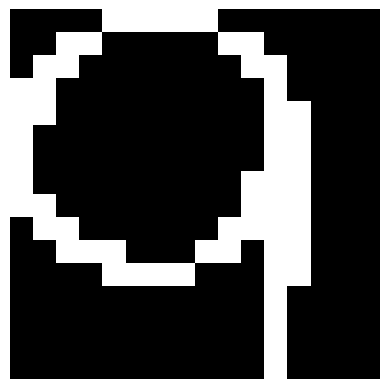

In [241]:
idx = random.randint(0, 1024)

if idx == 102: # line that is broken
    idx = 0

# plot the image
plt.imshow(images[idx], cmap='gray')
plt.axis('off') 
plt.show()

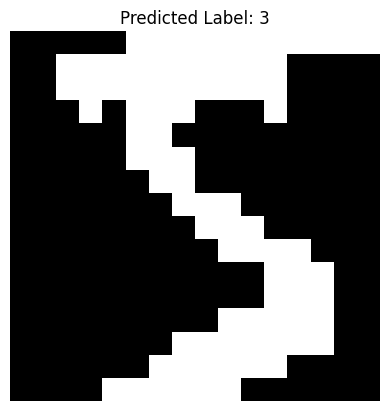

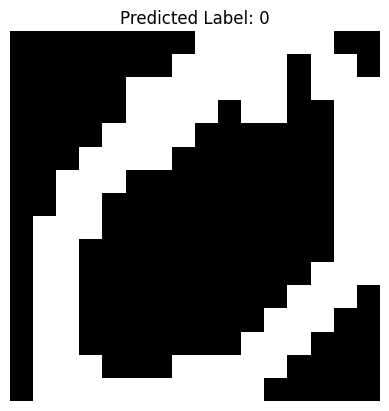

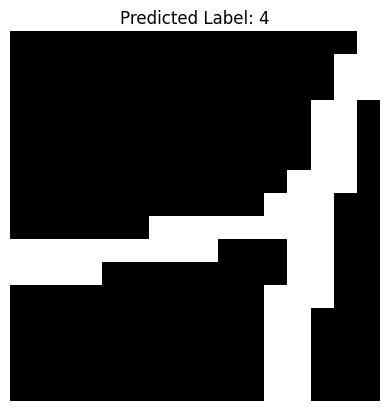

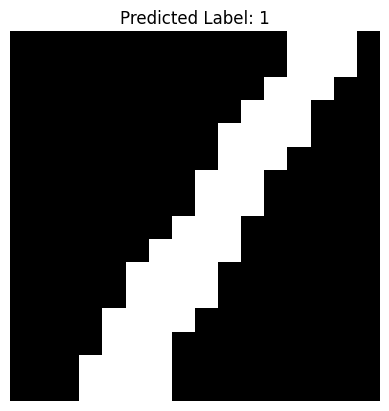

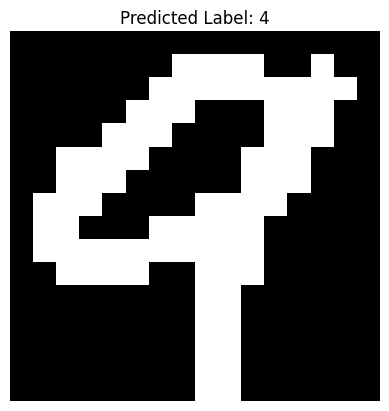

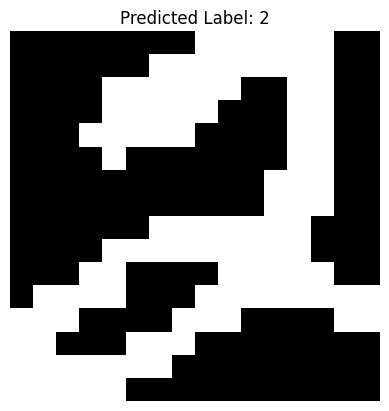

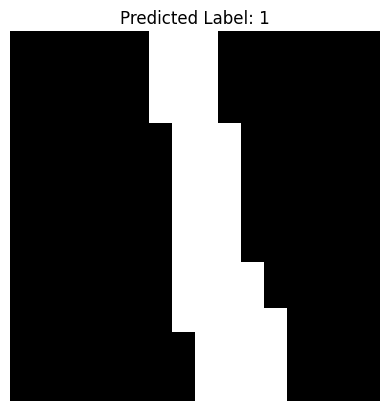

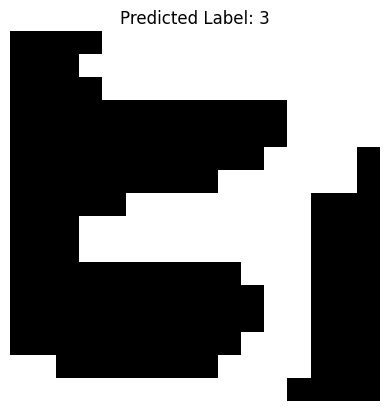

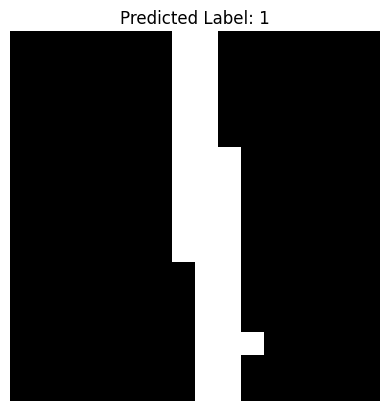

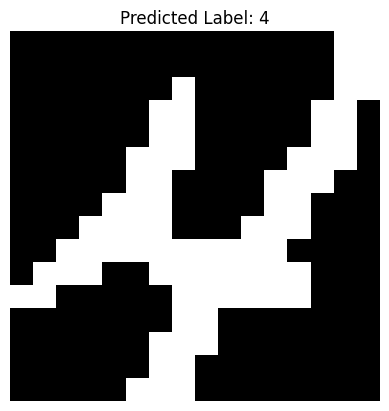

In [283]:
def run_inference_on_images(model, images):
    model.eval()  # sets model to evaluation mode
    predictions = []
    
    for img in images:
        # flatten each 16x16 image to a 1D tensor with 256 elements
        input_data = torch.tensor(img.flatten(), dtype=torch.float32).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        with torch.no_grad():  # disable gradient computation for inference
            output = model(input_data)
            _, predicted_label = torch.max(output, 1)  # get the predicted label
            predictions.append(predicted_label.item())
    
    return predictions

predictions = run_inference_on_images(trained_models[0], images)

# displays some sample images with predictions
for i in range(10):  
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Predicted Label: {predictions[i]}")
    plt.axis('off')
    plt.show()